<a href="https://colab.research.google.com/github/malloyca/steelpan-pitch/blob/main/feature-pitch/essentia_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essentia feature extraction notebook

Need to pip install Essentia then import libraries.

In [2]:
!pip install essentia

     |████████████████████████████████| 13.7 MB 8.3 kB/s 


In [20]:
import numpy as np
import essentia
import essentia.standard as es
import IPython.display as ipd

%matplotlib inline
import matplotlib.pyplot as plt


In [9]:
# todo - remove? This isn't needed if using gdown to download the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download the dataset and unzip.

In [6]:
!gdown --id 11XJkTaXDPwwvySUqfdJXxtDnSTDfDwTl

Downloading...
From: https://drive.google.com/uc?id=11XJkTaXDPwwvySUqfdJXxtDnSTDfDwTl
To: /content/tiny.zip
100% 602M/602M [00:11<00:00, 50.5MB/s]


In [7]:
!unzip tiny.zip
#!rm tiny.zip

Archive:  tiny.zip
   creating: tiny/
  inflating: tiny/.DS_Store          
  inflating: __MACOSX/tiny/._.DS_Store  
   creating: tiny/train/
   creating: tiny/validation/
   creating: tiny/train/61/
   creating: tiny/train/66/
   creating: tiny/train/68/
   creating: tiny/train/69/
   creating: tiny/train/67/
   creating: tiny/train/60/
   creating: tiny/train/89/
   creating: tiny/train/73/
   creating: tiny/train/87/
   creating: tiny/train/80/
   creating: tiny/train/74/
   creating: tiny/train/75/
   creating: tiny/train/81/
   creating: tiny/train/86/
   creating: tiny/train/72/
   creating: tiny/train/88/
   creating: tiny/train/65/
   creating: tiny/train/62/
   creating: tiny/train/63/
   creating: tiny/train/64/
   creating: tiny/train/79/
   creating: tiny/train/83/
   creating: tiny/train/77/
   creating: tiny/train/70/
   creating: tiny/train/84/
   creating: tiny/train/85/
   creating: tiny/train/71/
   creating: tiny/train/76/
   creating: tiny/train/82/
   creating: tin

# Essentia setup

In [12]:
test_file = '/content/tiny/train/60/60_train_sample_101.wav'

loader = es.MonoLoader(filename=test_file)
test_audio = loader()

In [13]:
ipd.Audio(test_file)

In [33]:

window = es.Windowing(type='hann')
spectrum = es.Spectrum()
mfcc = es.MFCC()

In [35]:
test_frame = test_audio[int(0.25*44100) : int(0.25*44100) + 1024]
frame_spectrum = spectrum(window(test_frame))
mfcc_bands, mfcc_coeffs = mfcc(frame_spectrum)

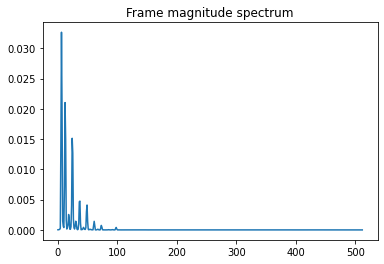

In [36]:
plt.plot(frame_spectrum)
plt.title("Frame magnitude spectrum")
plt.show()

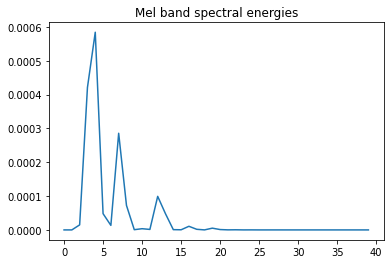

In [37]:
plt.plot(mfcc_bands)
plt.title("Mel band spectral energies")
plt.show()

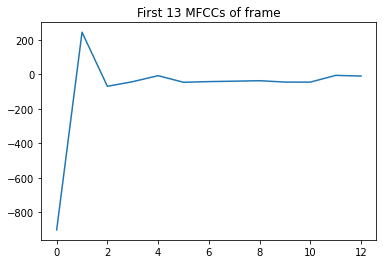

In [38]:
plt.plot(mfcc_coeffs)
plt.title("First 13 MFCCs of frame")
plt.show()

### Doing computations on all frames of an audio file

In [39]:
mfccs = []
mel_bands = []
frame_size = 1024
hop_size = 512

In [40]:
for frame in es.FrameGenerator(test_audio, frameSize=frame_size, hopSize=hop_size, startFromZero=True):
  mfcc_bands, mfcc_coeffs = mfcc(spectrum(window(frame)))
  mfccs.append(mfcc_coeffs)
  mel_bands.append(mfcc_bands)

In [41]:
mfccs = essentia.array(mfccs).T
mel_bands = essentia.array(mel_bands).T

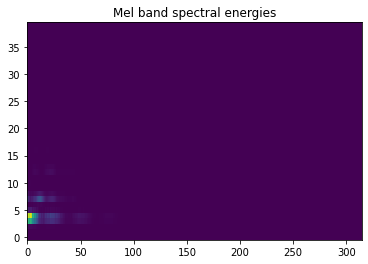

In [42]:
plt.imshow(mel_bands[:,:], aspect='auto', origin='lower', interpolation='none')
plt.title("Mel band spectral energies")
plt.show()

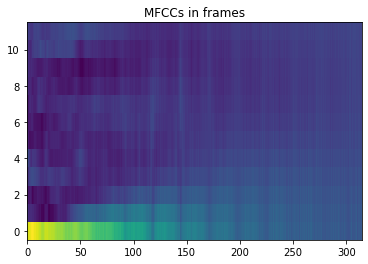

In [43]:
plt.imshow(mfccs[1:,:], aspect='auto', origin='lower', interpolation='none')
plt.title("MFCCs in frames")
plt.show()

## Essentia pools

In [45]:
pool = essentia.Pool()

In [46]:
for frame in es.FrameGenerator(test_audio, frameSize=frame_size, hopSize=hop_size, startFromZero=True):
  mfcc_bands, mfcc_coeffs = mfcc(spectrum(window(frame)))
  pool.add('lowlevel.mfcc', mfcc_coeffs)
  pool.add('lowlevel.mfcc_bands', mfcc_bands)

In [47]:
np.savetxt('/content/data.csv', pool, delimiter=',')

ValueError: ignored